In [1]:
import os
from PIL import Image, ImageFilter

# Original dataset dir
input_dir = 'target_photos'
# Dataset with old-photo effects
output_dir = 'input_photos'

file_list = os.listdir(input_dir)

for filename in file_list:
    input_filepath = os.path.join(input_dir, filename)
    
    if filename.lower().endswith('.jpeg'):
        pic = Image.open(input_filepath)
        
        # Apply blur effect
        blur_radius = 3
        pic_blur = pic.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        
        # Apply 'sepia' effect
        for x in range(pic_blur.size[0]):
            for y in range(pic_blur.size[1]):
                r, g, b = pic_blur.getpixel((x, y))
                tr = int(.393 * r + .769 * g + .189 * b)
                tg = int(.349 * r + .686 * g + .131 * b)
                tb = int(.272 * r + .534 * g + .131 * b)
                pic_blur.putpixel((x, y), (tr, tg, tb))
        
        # Save images on the input_photos directory
        output_filepath = os.path.join(output_dir, filename)
        pic_blur.save(output_filepath)

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Root path
PATH = ""

# Input data path
INPATH = PATH + 'input_photos'
# Output data path
OUPATH = PATH + 'target_photos'
# Checkpoints path
CKPATH = PATH + 'checkpoints'

imgurls = !ls -1 "{INPATH}"

n = 500
train_n = round(n * 0.80)

# Randomized list
randurls = np.copy(imgurls)

np.random.shuffle(randurls)

# Train/Test partition
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

7703 400 100


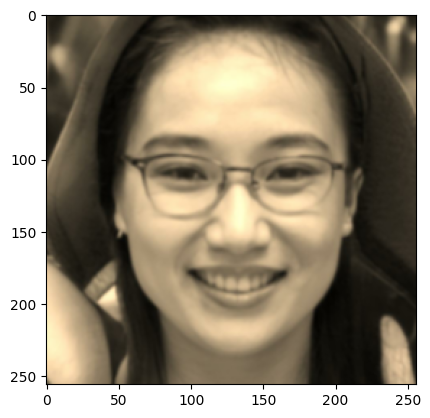

In [18]:
IMG_WIDTH = 256
IMG_HEIGHT = 256


# Rescale images
def resize(inimg, tgimg, height, width):
    inimg = tf.image.resize(inimg, [height, width])
    tgimg = tf.image.resize(tgimg, [height, width])

    return inimg, tgimg


# Normalize images in a [-1, +1] range
def normalize(inimg, tgimg):
    inimg = (inimg / 127.5) - 1
    tgimg = (tgimg / 127.5) - 1

    return inimg, tgimg

@tf.function()
# Data augmentation: Random Crop + Flip
def random_jitter(inimg, tgimg):
    inimg, tgimg = resize(inimg, tgimg, 286, 286)

    stacked_image = tf.stack([inimg, tgimg], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    inimg, tgimg = cropped_image[0], cropped_image[1]

    if tf.random.uniform(()) > 0.5:

        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg, tgimg


def load_image(filename, augment=True):

    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[...,:3]
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[...,:3]

    inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

    if augment:
        inimg, tgimg = random_jitter(inimg, tgimg)

    inimg, tgimg = normalize(inimg, tgimg)

    return inimg, tgimg

def load_train_image(filename):
    return load_image(filename, True)

def load_test_image(filename):
    return load_image(filename, False)

plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)

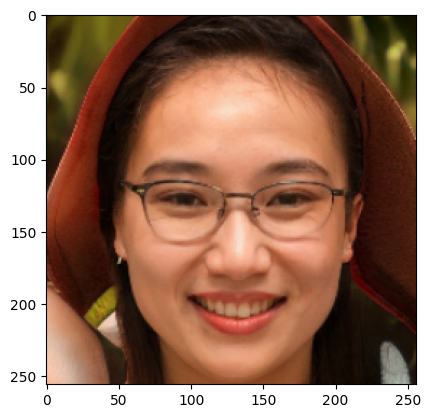

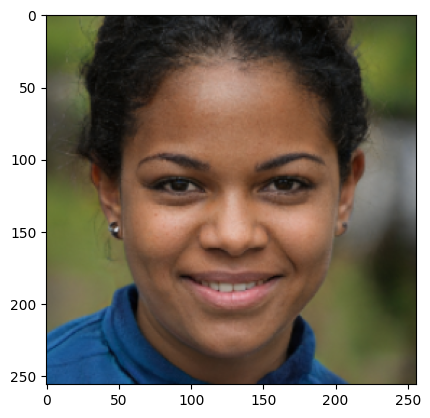

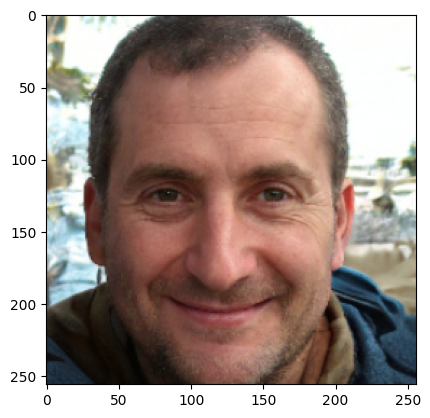

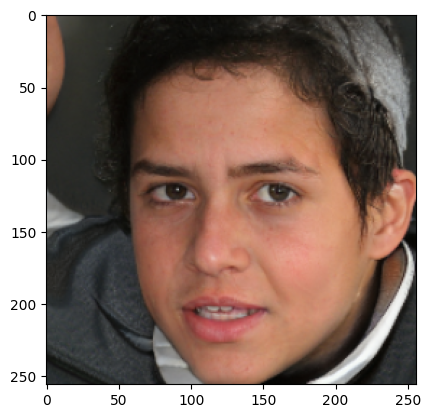

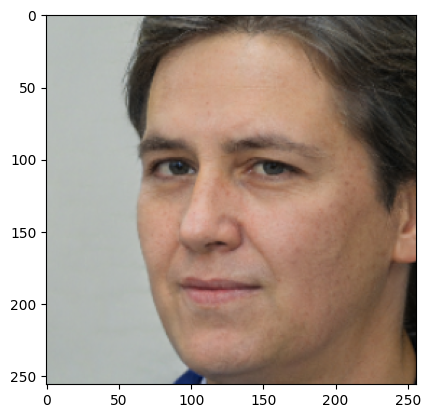

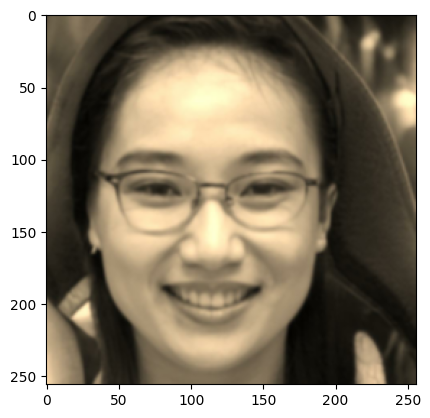

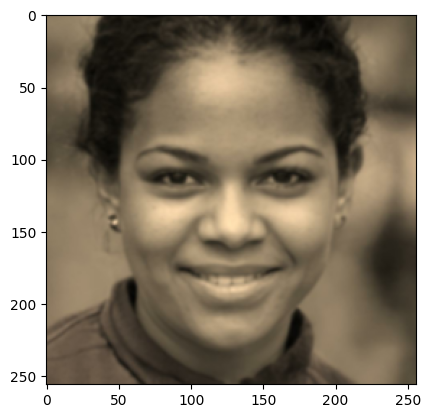

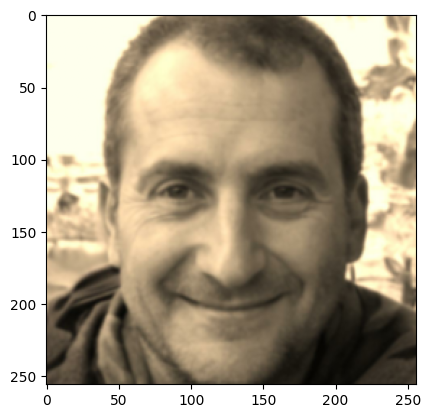

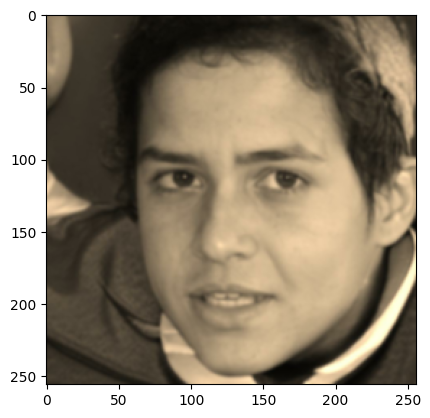

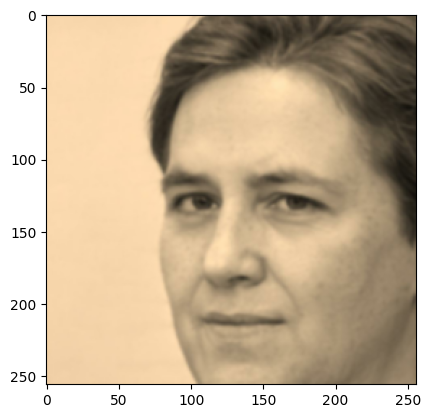

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inimg, tgimg in train_dataset.take(5):
    plt.imshow(((tgimg[0,...]) + 1) / 2)
    plt.show()
    
for inimg, tgimg in train_dataset.take(5):

    plt.imshow(((inimg[0,...]) + 1) / 2)
    plt.show()

In [20]:
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

def downsample(filters, apply_batchnorm = True):

    result = Sequential()

    initializer = tf.random_normal_initializer(0, 0.02)
    
    # Convolutional layer
    result.add(Conv2D(filters,
                      kernel_size = 4,
                      strides = 2,
                      padding = "same",
                      kernel_initializer=initializer,
                      use_bias = not apply_batchnorm))

    # BatchNorm layer
    if apply_batchnorm:
        result.add(BatchNormalization())

    # Activation layer
    result.add(LeakyReLU())

    return result

downsample(64)

In [21]:
def upsample(filters, apply_dropout = True):

    result = Sequential()

    initializer = tf.random_normal_initializer(0, 0.02)
    
    # Convolutional layer
    result.add(Conv2DTranspose(filters,
                              kernel_size = 4,
                              strides = 2,
                              padding = "same",
                              kernel_initializer=initializer,
                              use_bias = False))

    # BatchNorm layer
    result.add(BatchNormalization())

    # Dropout layer
    if apply_dropout:
        result.add(Dropout(0.5))

    # Activation layer
    result.add(LeakyReLU())

    return result

upsample(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


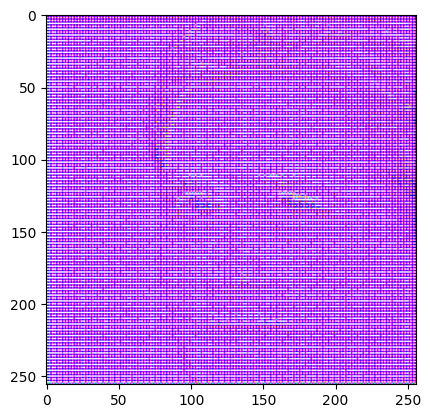

In [22]:
def Generator():

    inputs = tf.keras.layers.Input(shape = [None, None, 3])

    down_stack = [
        downsample(64, apply_batchnorm=False),
        downsample(128),
        downsample(256),
        downsample(512),
        downsample(512),
        downsample(512),
        downsample(512),
        downsample(512),
    ]

    up_stack = [
        upsample(512, apply_dropout=True),
        upsample(512, apply_dropout=True),
        upsample(512, apply_dropout=True),
        upsample(512),
        upsample(256),
        upsample(128),
        upsample(64),
    ]

    initializer = tf.random_normal_initializer(0, 0.02)
    
    last = Conv2DTranspose(filters = 3,
                           kernel_size = 4,
                           strides = 2,
                           padding = "same",
                           kernel_initializer = initializer,
                           activation = "tanh")

    x = inputs
    s = []

    concat = Concatenate()
    
    for down in down_stack:
        x = down(x)
        s.append(x)

    s = reversed(s[:-1])

    for up, sk in zip(up_stack, s):
        
        x = up(x)
        x = concat([x, sk])

    last = last(x)
    
    return tf.keras.Model(inputs = inputs, outputs = last)

generator = Generator()
gen_output = generator(((inimg +1)*255), training=False)
plt.imshow(gen_output[0,...])

TensorShape([1, 16, 16, 1])

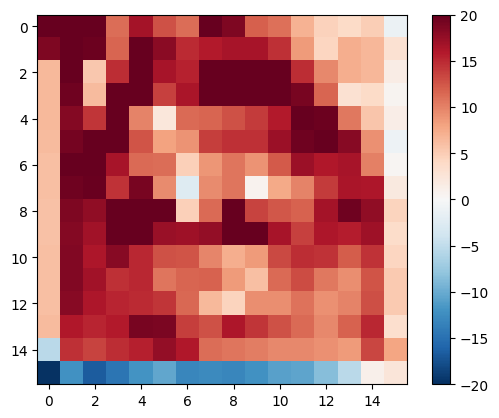

In [23]:
def Discriminator():
    
    ini = Input(shape = [None, None, 3], name = "input_img")
    gen = Input(shape = [None, None, 3], name = "gener_img")
    
    con = concatenate([ini, gen])

    initializer = tf.random_normal_initializer(0, 0.02)

    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)

    last = tf.keras.layers.Conv2D(filters = 1,
                                  kernel_size = 4,
                                  strides = 1,
                                  kernel_initializer=initializer,
                                  padding = "same")(down4)

    return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

disc_out = discriminator([((inimg+1)*255), gen_output], training = False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap = 'RdBu_r')
plt.colorbar()
disc_out.shape

In [24]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):

    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [26]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [27]:
# Restore progress in case of failure
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

AssertionError: No checkpoint specified (save_path=None); nothing is being restored.

In [28]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

    prediction = model(test_input, training=True)

    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH + 'output/' + save_filename + '.jpg', prediction[0,...])

    plt.figure(figsize=(10,10))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    if display_imgs:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')

    plt.show()

In [29]:
@tf.function()
def train_step(input_image, target):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
        output_image = generator(input_image, training=True)
    
        output_gen_discr = discriminator([output_image, input_image], training=True)
    
        output_trg_discr = discriminator([target, input_image], training=True)
    
        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    
        gen_loss = generator_loss(output_gen_discr, output_image, target)

        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

        discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [30]:
from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):

        imgi = 0
        for input_image, target in dataset:
            print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
            imgi += 1
            train_step(input_image, target)
            clear_output(wait=True)
            
        imgi = 0
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
            imgi += 1

        # Saving (checkpoints) the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

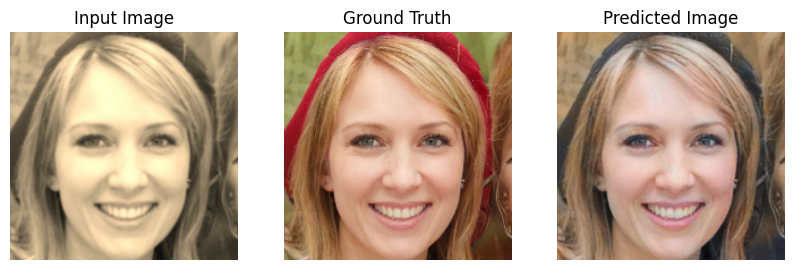

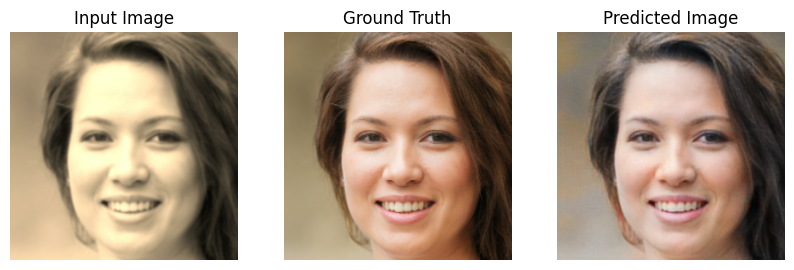

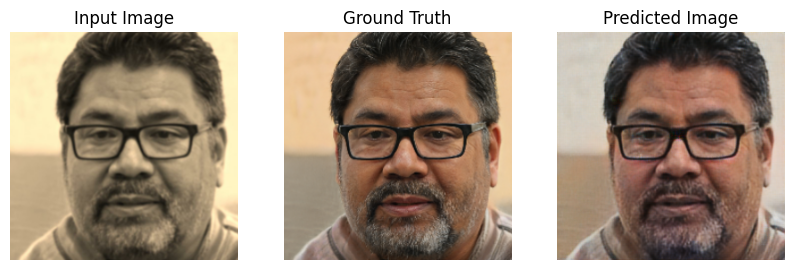

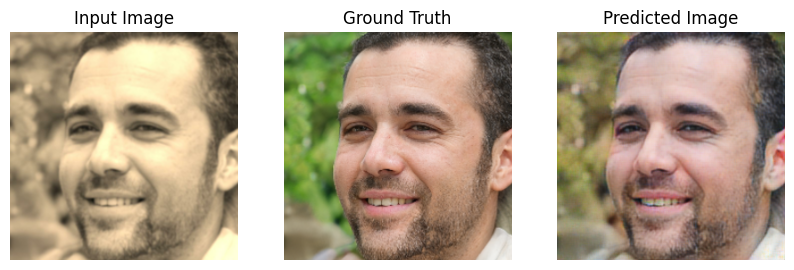

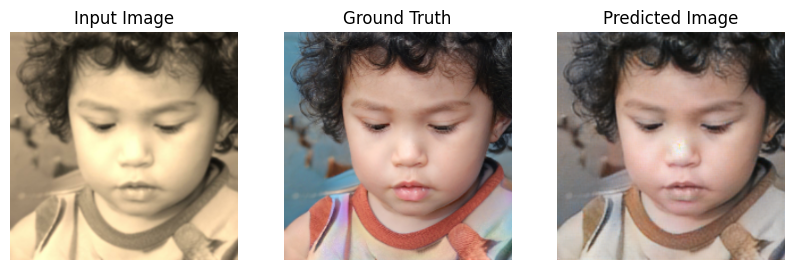

In [31]:
train(train_dataset, 300)